## SECOND TASK: RUSSET DETECTION

In [93]:
# Import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance

# Load pics
dirname = "second task/"
NIR_img_names = [dirname + "C0_00000" + str(i) + ".png" for i in range(4,6)]
Col_img_names = [dirname + "C1_00000" + str(i) + ".png" for i in range(4,6)]

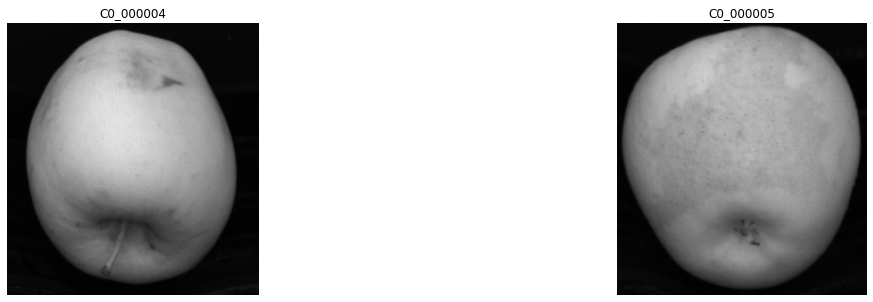

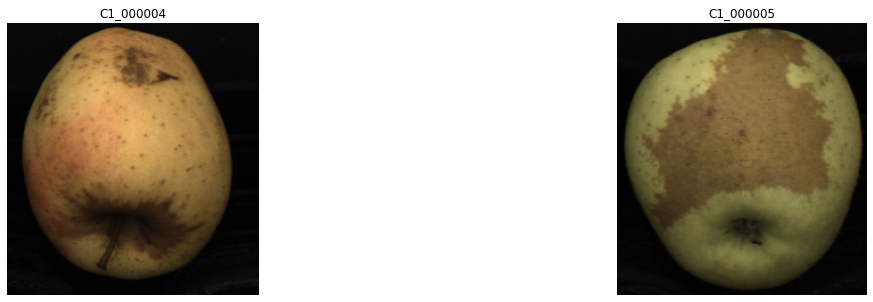

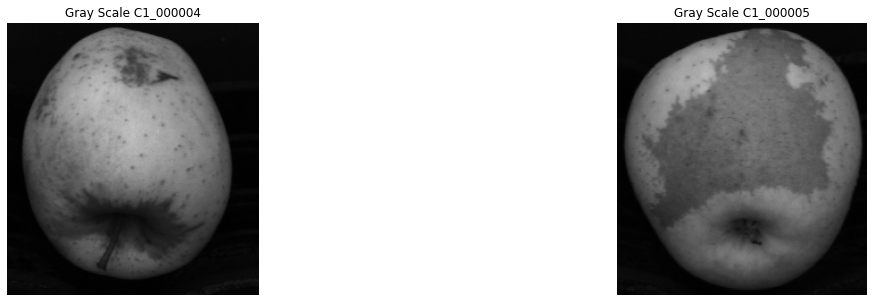

In [94]:
# Loading of Infarared Images
img_NIR = []
j = 0
plt.figure(figsize=(20,5))
for i in NIR_img_names:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_NIR.append(img)
    plt.subplot(1,2,j+1).axis("off")
    plt.title("C0_00000{}".format(j+4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    j = j+1
plt.show()

# Loading of Colored Images
img_gray = []
img_RGB = []
j = 0
plt.figure(figsize=(20,5))
for i in Col_img_names:
    img_BGR = cv2.imread(i)
    rgb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_RGB.append(rgb)
    gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    img_gray.append(gray)
    plt.subplot(1,2,j+1).axis("off")
    plt.title("C1_00000{}".format(j+4))
    plt.imshow(rgb)
    j = j+1   
plt.show()

j = 0
plt.figure(figsize=(20,5))
for i in Col_img_names:
    plt.subplot(1,2,j+1).axis("off")
    plt.title("Gray Scale C1_00000{}".format(j+4))
    plt.imshow(img_gray[j], cmap='gray', vmin=0, vmax=255) 
    j = j+1   
plt.show()

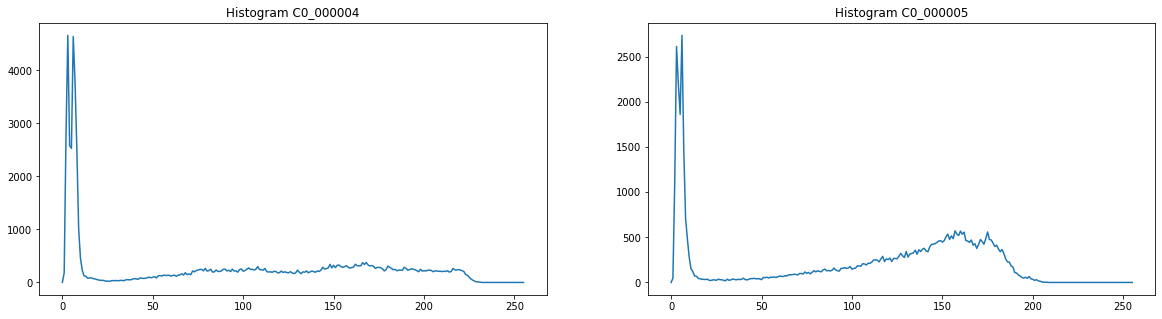

In [95]:
#Histogram plotting
plt.figure(figsize=(20,5))
j = 0
for i in img_NIR:
    hist, bins = np.histogram(i.flatten(),256,[0,256])
    plt.subplot(1,2,j+1)
    plt.title("Histogram C0_00000{}".format(j+4))
    plt.plot(hist)
    j = j+1
plt.show()

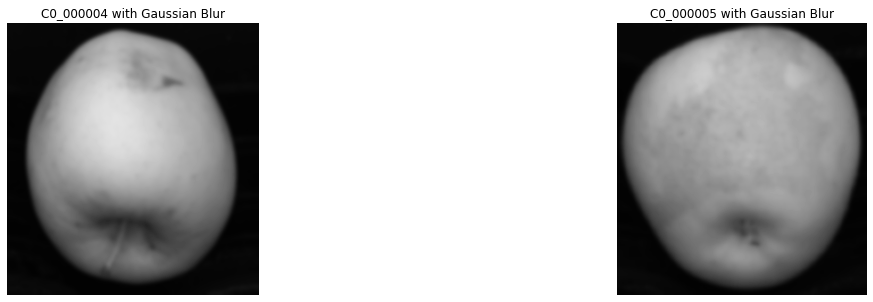

In [96]:
#Application of a Gaussian Blur
blur = []
plt.figure(figsize=(20,5))
j = 0
for i in img_NIR:
    blur_temp = cv2.GaussianBlur(i,(9,9),0)
    blur.append(blur_temp)
    plt.subplot(1,2,j+1).axis("off")
    plt.title("C0_00000{} with Gaussian Blur".format(j+4))
    plt.imshow(blur[j], cmap='gray', vmin=0, vmax=255)
    j = j+1

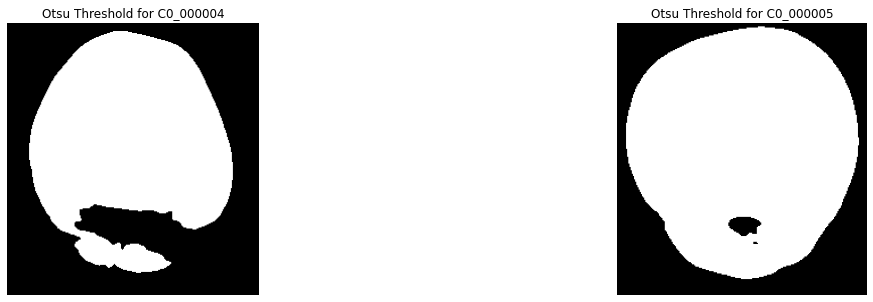

In [97]:
#Otsu Thresholding to segment the image
otsu = []
plt.figure(figsize=(20,5))
j = 0
for i in img_NIR:
    th, otsu_temp = cv2.threshold(blur[j], 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    otsu.append(otsu_temp)
    plt.subplot(1,2,j+1).axis("off")
    plt.title("Otsu Threshold for C0_00000{}".format(j+4))
    plt.imshow(otsu[j] ,cmap='gray', vmin=0, vmax=255)
    j = j+1

Canny after a bilateral filter of infrared images


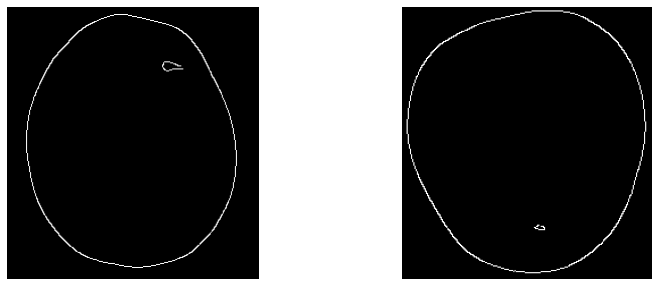

In [98]:
print("Canny after a bilateral filter of infrared images")
j = 0
plt.figure(figsize=(20,5))
edges=[]

for i in img_NIR:
    i = i.astype(np.uint8)
    img_bilateral = cv2.bilateralFilter(i,11,35,35)  #9, 35, 35
    plt.subplot(1,3,j+1).axis("off")
    #plt.imshow(img_bilateral, cmap='gray', vmin=0, vmax=255)
    j = j+1
    edges_temp = cv2.Canny(img_bilateral, 50, 130)  #50, 150
    edges.append(edges_temp)
    plt.imshow(edges_temp, cmap='gray', vmin=0, vmax=255)
plt.show()

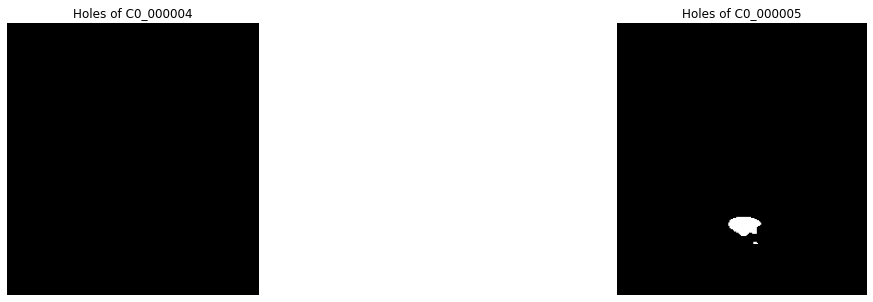

In [99]:
#filling of the holes inside the fruit blob
holes = []
plt.figure(figsize=(20,5))
j = 0
for i in img_NIR:
    h, w = otsu[j].shape[:2]
    m1 = np.zeros((h+2, w+2), np.uint8)
    ff1 = otsu[j].copy()
    cv2.floodFill(ff1, m1, (0,0), 255)
    holes_temp = cv2.bitwise_not(ff1)
    holes.append(holes_temp)
    plt.subplot(1,2,j+1).axis("off")
    plt.title("Holes of C0_00000{}".format(j+4))
    plt.imshow(holes[j], cmap='gray', vmin=0, vmax=255)
    j = j+1

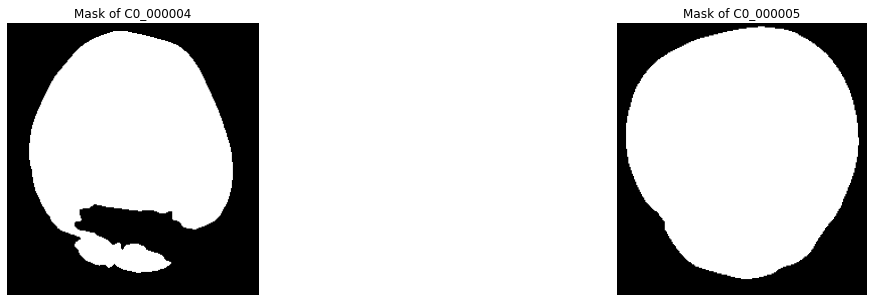

In [100]:
#Mask of the apples
#The image pair has little parallax, so a mask might be computed on one image and then applied on the other one.
mask = []
mask_c = []
plt.figure(figsize=(20,5))
j = 0
for i in img_NIR:
    mask_temp = holes[j] | otsu[j]
    mask.append(mask_temp)
    mask_c_temp = cv2.cvtColor(mask[j], cv2.COLOR_GRAY2RGB) 
    mask_c.append(mask_c_temp)
    plt.subplot(1,2,j+1).axis("off")
    plt.title("Mask of C0_00000{}".format(j+4))
    plt.imshow(mask[j], cmap='gray', vmin=0, vmax=255)
    j = j+1


#In this case, filling in the holes inside the blob is not enough for a complete mask so we must continue.

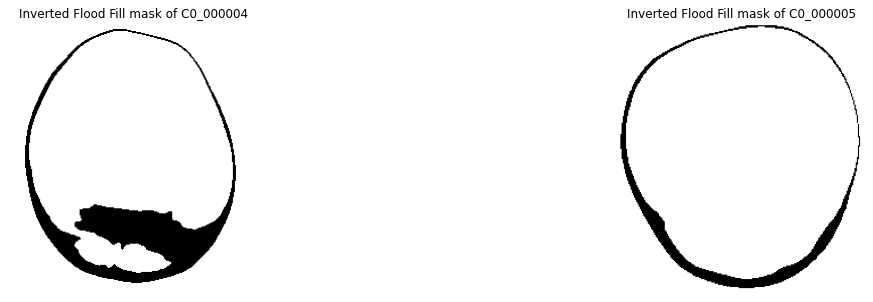

In [101]:
#filling out the mask using a flood fill approach

#We use the the Canny borders found earlier as a way to fill the image with white
#stopping only at the border (which remains black). Thus what remains is the border
#plus the black "incomplete" parts of the mask
#edge detector output can be used as a mask to stop filling at edges

plt.figure(figsize=(20,5))
j = 0

mask_ff=[]
for i in mask:
    h, w = i.shape[:2]
    m1 = np.zeros((h+2, w+2), np.uint8)
    ff2 = i.copy()

    row_ff=np.zeros((2, w))
    col_ff=np.zeros((h+2, 2))
    
    n_mask=~mask[j]
    mask_ff_temp=np.vstack((edges[j], row_ff))
    #print(mask_ff_temp.shape)
    #print(col_ff.shape)
    mask_ff_temp=np.hstack((mask_ff_temp, col_ff))
    #print(mask_ff_temp.shape)
    mask_ff_temp = mask_ff_temp.astype(np.uint8)

    cv2.floodFill(ff2, mask_ff_temp, (0,0), 255)

    mask_ff.append(ff2)

    plt.subplot(1,2,j+1).axis("off")
    plt.title("Inverted Flood Fill mask of C0_00000{}".format(j+4))
    plt.imshow(ff2, cmap='gray', vmin=0, vmax=255)
    j = j+1

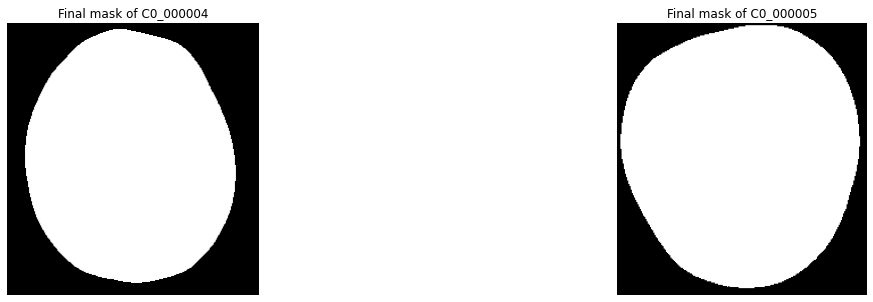

In [102]:
##FINAL MASK 

#Flood Fill mask is inverted. (Inverted Flood Fill) OR (Incompete Mask) = (Complete Mask)

plt.figure(figsize=(20,5))
j = 0
mask_fin=[]
mask_fin_c=[]

for i in mask_ff:
    i=~i
    mask_fin_temp=mask[j] | i

    mask_fin.append(mask_fin_temp)
    mask_fin_c.append(cv2.cvtColor(mask_fin[j], cv2.COLOR_GRAY2RGB))
    
    plt.subplot(1,2,j+1).axis("off")
    plt.title("Final mask of C0_00000{}".format(j+4))
    plt.imshow(mask_fin_temp, cmap='gray', vmin=0, vmax=255)
    j = j+1

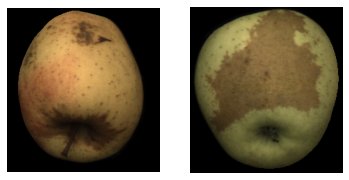

<Figure size 1440x360 with 0 Axes>

In [103]:
##Creating the masked images
#plt.figure(figsize=(20,5))
j = 0
bool_mask=[]
bool_mask_c=[]
app_rgb=[]
app_gray=[]

for i in mask_fin_c:
    ones = np.ones(img_RGB[j].shape, dtype=int)
    bool_mask_temp = ones & i
    bool_mask_c.append(bool_mask_temp)
    #m_im1_c = cv2.bitwise_or(im1_c, mask1_c)
    #print(mask_c[j].shape)
    #print(i.shape)
    app_rgb.append(img_RGB[j] * bool_mask_c[j])
    plt.subplot(1,2,j+1).axis("off")
    plt.imshow(app_rgb[j], cmap='gray', vmin=0, vmax=255)
    j = j+1
plt.show()


plt.figure(figsize=(20,5))
j=0
for i in mask_fin:
    ones = np.ones(img_NIR[j].shape, dtype=int)
    bool_mask_temp = ones & i
    bool_mask.append(bool_mask_temp)
    #m_im1_c = cv2.bitwise_or(im1_c, mask1_c)
    #print(mask_c[j].shape)
    #print(i.shape)
    app_gray.append(img_gray[j] * bool_mask[j])
    #plt.subplot(1,2,j+1).axis("off")
    #plt.imshow(app_gray[j], cmap='gray', vmin=0, vmax=255)
    j = j+1
#plt.show()

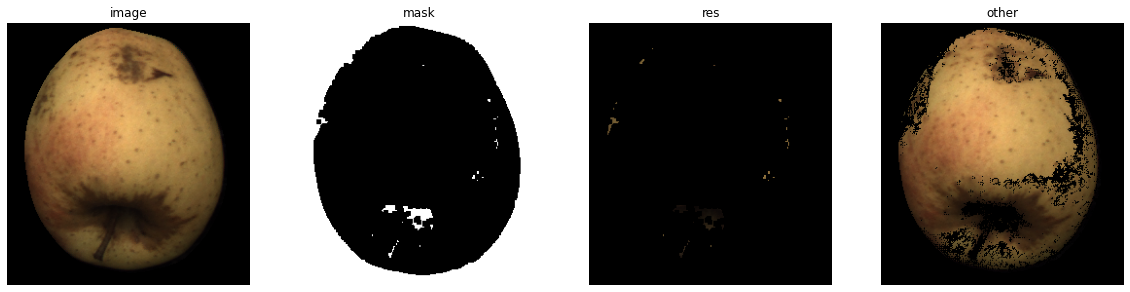

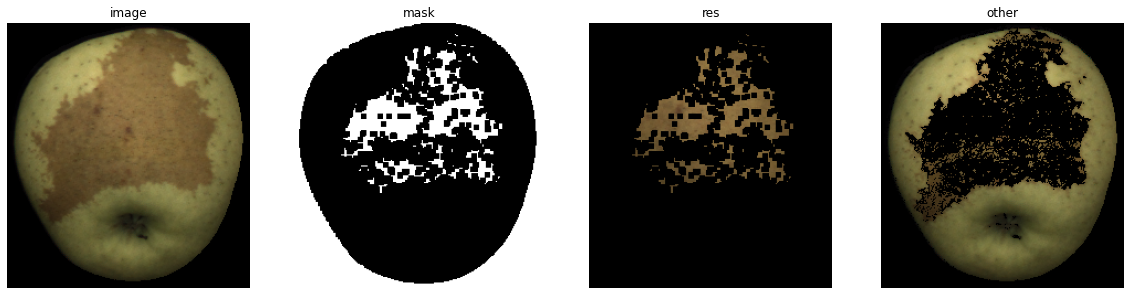

In [104]:
### EXECUTION OF IN RANGE OPERATIONS


#Using a Colour Selector Program we found a good range where the brown of the russetes
#is mostly selected and the rest of the apple is filtered out.

#Once we have the brown pixels we then subsequently use erode operation to select a set of pixels around our russet 
#colour pixels
#We now have a new mask of Russet brown pixels which selects the surrounding pixels as well. We can use this to calculate
#average russett colour and avg non-russett colour.
j=0
RANGE = []
NOT_RANGE = []
for image in app_rgb:
    
    img = (image.copy()).astype('uint8')
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # define range
    lower_brown = np.array([0,0,0])
    upper_brown = np.array([20,152,150])
    # Threshold the HSV image to get only brown colors
    mask = cv2.inRange(hsv, lower_brown, upper_brown)
    kernel = np.ones((5,5), np.uint8)
    nu_mask = cv2.erode(mask, kernel)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= nu_mask)
    RANGE.append(res)
    other = img - cv2.bitwise_and(img,img, mask= mask)
    NOT_RANGE.append(other)
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1).axis("off")
    plt.title("image")
    plt.imshow(img)
    plt.subplot(1,4,2).axis("off")
    plt.title("mask")
    plt.imshow(nu_mask, cmap='gray')
    plt.subplot(1,4,3).axis("off")
    plt.title("res")
    plt.imshow(res)
    plt.subplot(1,4,4).axis("off")
    plt.title("other")
    plt.imshow(other)
    plt.show()

In [105]:
### CALCULATION OF MEANs AND COVs 
print("----------------------------------------------------------------\n")
print("MEAN RANGE\n")
j=0
MEAN_R = []
INVCOV_R=[]
for image in RANGE:
    
    SLT = []
    BKG = []
    for a in range(image.shape[0]):
        for b in range(image.shape[1]):
            pix = image[a,b,:]
            if (pix[0] != 0 and pix[1] != 0 and pix[2] != 0):
                SLT.append(pix)
            else:
                BKG.append(pix)
    print("APPLE",j+1,"-> Colored pixels:",len(SLT),". Black pixels:", len(BKG))

    SLT = np.array(SLT).astype('uint8')
    mean = np.mean(SLT, axis=0)
    MEAN_R.append(mean)
    print("Mean:",mean,"\n")

    # cov = np.cov(SLT.T)
    # print("Covariance Matrix:\n",cov)
    # invcov = np.linalg.pinv(cov)
    # print("Inverse Covariance Matrix:\n",invcov,"\n")
    # INVCOV_R.append(invcov)

    j=j+1
print("\n----------------------------------------------------------------\n")
print("MEAN NOT RANGE\n")
j=0
MEAN_NR = []
INVCOV_NR=[]
for image in NOT_RANGE:
    
    SLT = []
    BKG = []
    for a in range(image.shape[0]):
        for b in range(image.shape[1]):
            pix = image[a,b,:]
            if (pix[0] != 0 and pix[1] != 0 and pix[2] != 0):
                SLT.append(pix)
            else:
                BKG.append(pix)
    print("APPLE",j+1,"-> Colored pixels:",len(SLT),". Black pixels:", len(BKG))

    SLT = np.array(SLT).astype('uint8')
    mean = np.mean(SLT, axis=0)
    MEAN_NR.append(mean)
    print("Mean:",mean,"\n")

    # cov = np.cov(SLT.T)
    # print("Covariance Matrix:\n",cov)
    # invcov = np.linalg.pinv(cov)
    # print("Inverse Covariance Matrix:\n",invcov,"\n")
    # INVCOV_NR.append(invcov)

    j=j+1
print("\n----------------------------------------------------------------\n")
print("COVARIANCE MATRICES\n")
j=0
INVCOV = []
for image in app_rgb:
    
    SLT = []
    BKG = []
    for a in range(image.shape[0]):
        for b in range(image.shape[1]):
            pix = image[a,b,:]
            if (pix[0] != 0 and pix[1] != 0 and pix[2] != 0):
                SLT.append(pix)
            else:
                BKG.append(pix)
    print("APPLE",j+1,"-> Colored pixels:",len(SLT),". Black pixels:", len(BKG))

    SLT = np.array(SLT).astype('uint8')
    cov = np.cov(SLT.T)
    print("Covariance Matrix:\n",cov)
    invcov = np.linalg.pinv(cov)
    print("Inverse Covariance Matrix:\n",invcov,"\n")
    INVCOV.append(invcov)

    j=j+1

----------------------------------------------------------------

MEAN RANGE

APPLE 1 -> Colored pixels: 547 . Black pixels: 66953
Mean: [46.89031079 35.68738574 21.23583181] 

APPLE 2 -> Colored pixels: 4966 . Black pixels: 47834
Mean: [123.6804269   98.25211438  56.07974225] 


----------------------------------------------------------------

MEAN NOT RANGE

APPLE 1 -> Colored pixels: 34435 . Black pixels: 33065
Mean: [136.27861188  99.97215043  55.09266734] 

APPLE 2 -> Colored pixels: 24041 . Black pixels: 28759
Mean: [102.57135726  95.68499646  53.24795142] 


----------------------------------------------------------------

COVARIANCE MATRICES

APPLE 1 -> Colored pixels: 41208 . Black pixels: 26292
Covariance Matrix:
 [[3753.91619096 2890.31414618 1662.01927925]
 [2890.31414618 2273.64729881 1301.6583647 ]
 [1662.01927925 1301.6583647   753.7547238 ]]
Inverse Covariance Matrix:
 [[ 0.01362049 -0.01064463 -0.01165081]
 [-0.01064463  0.04705667 -0.05779087]
 [-0.01165081 -0.0577908

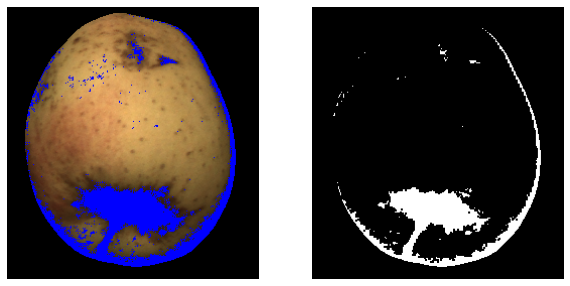

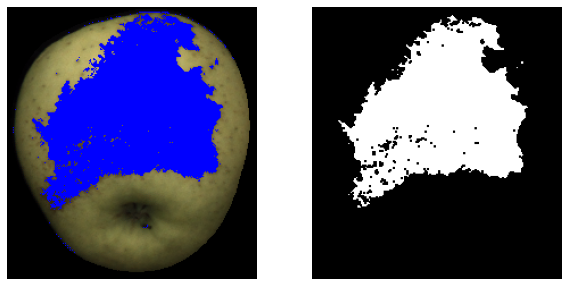

In [106]:
### DISTANCE CALCULATIONS and russet marking
from scipy.spatial import distance
j=0
STAINS=[]
for image in app_rgb:

    canvas = image.copy()
    blank = np.zeros((canvas.shape[0],canvas.shape[1]), dtype=np.uint8)
    #image = cv2.medianBlur(image.astype('uint8'),5)
    for a in range(image.shape[0]):
        for b in range(image.shape[1]):
            pix = image[a,b,:]
            if (pix[0] != 0 and pix[1] != 0 and pix[2] != 0):
                dst1 = distance.mahalanobis(pix,MEAN_R[j],INVCOV[j])
                dst2 = distance.mahalanobis(pix,MEAN_NR[j],INVCOV[j])
                if dst1 < dst2:
                    canvas[a,b] = [0,0,255]
                    blank[a,b] = 255

    kernel = np.ones((2,2), np.uint8)
    blank = cv2.erode(blank, kernel)
    STAINS.append(blank)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1).axis("off")
    plt.imshow(canvas)
    plt.subplot(1,2,2).axis("off")
    plt.imshow(blank, cmap='gray', vmin=0, vmax=255)
    plt.show()

    j=j+1


Number of russet areas in C0_000004: 3


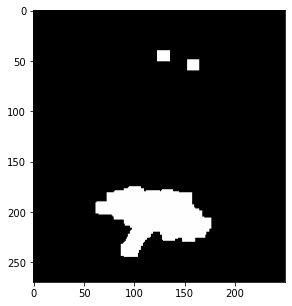

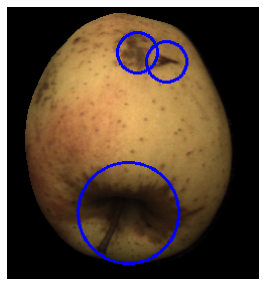

Number of russet areas in C0_000005: 1


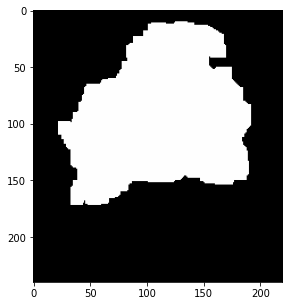

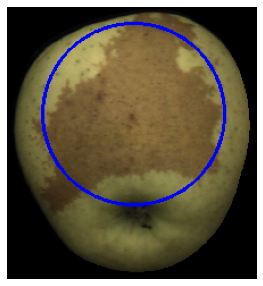

In [107]:
### POLISHING RESULTS
j=0
n_blobs = []
FINALS=[]
for raw in STAINS:

    # Dilate the edges (obtained with canny) and remove the elements inside them using the mask
    edge = edges[j].copy()
    kernel = np.ones((5,5), np.uint8)
    edge_dil = cv2.dilate(edges[j], kernel)
    full = mask_fin[j].copy()
    borders = edge_dil - full

   
    # Dilate further the borders
    kernel = np.ones((19,19), np.uint8)
    borders_dil = cv2.dilate(borders, kernel)

    
    # Remove borders from detections
    # Scan rowwise and columnwise the stain image and the dilated border 
    # For each corresponding pixel if both have value 255 (i.e. if the pixel is present in both, that means that means that
    # it is part of the contour) we eliminate it.
    # Else if the pixel is present only in the stain image, we keep it.
    unpol = np.zeros((raw.shape[0],raw.shape[1]), dtype=np.uint8)
    for a in range(unpol.shape[0]):
        for b in range(unpol.shape[1]):
            x = raw[a,b]
            y = borders_dil[a,b]
            if x<y:
                unpol[a,b] = 0
            else:
                unpol[a,b] = (x-y)
    
    # Polish the new results (to obtain continous blobs and minimize false positives)
    kernel = np.ones((3,3), np.uint8)
    pol = cv2.morphologyEx(unpol, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((9,9), np.uint8)
    new = cv2.dilate(pol, kernel)

    plt.figure(figsize=(10,5))
    plt.imshow(new, cmap='gray', vmin=0, vmax=255)

    # Counting areas
    cnts = cv2.findContours(new, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    n_blobs_temp = 0
    for c in cnts:
        n_blobs_temp += 1
    n_blobs.append(n_blobs_temp)
    if n_blobs[j] > 0:
        #Print only if at least one defect is found
        print("Number of russet areas in C0_00000{}: ".format(j+4) + str(n_blobs[j]))

    finale = app_rgb[j].copy()
    for i in cnts:
        area = cv2.contourArea(i)
        area = int(area)
        M = cv2.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if area > 5000:
                radius = 80
            elif 1000 < area < 5000: 
                radius = 50
            else:
                radius = 20
            cv2.circle(finale, (cx, cy), radius, (0, 0, 255), 2)
        #print(f"x: {cx} y: {cy}")
    FINALS.append(finale)

    # plt.figure(figsize=(20,5))
    # plt.subplot(1,4,1).axis("off")
    # plt.imshow(raw, cmap='gray', vmin=0, vmax=255)
    # plt.subplot(1,4,2).axis("off")
    # plt.imshow(unpol, cmap='gray', vmin=0, vmax=255)
    # plt.subplot(1,4,3).axis("off")
    # plt.imshow(pol, cmap='gray', vmin=0, vmax=255)
    # plt.subplot(1,4,4).axis("off")
    # plt.imshow(new, cmap='gray', vmin=0, vmax=255)
    # plt.show()

    j=j+1
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,j).axis('off')
    plt.imshow(finale)   
    plt.show()